In [ ]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
cs461dir = '/content/drive/My Drive/Colab Notebooks/CS461/'

file_paths = ['examples.txt', 'wiki2.test.txt', 'wiki2.train.txt', 'wiki2.valid.txt']
if any(not os.path.exists(filepath) for filepath in file_paths):
  !cp -r "{cs461dir}"* /content/
  print("Files imported")

model_path = "./model_weights"
os.makedirs(model_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_corpus(file_name,vocab,words,corpus,threshold):

    wID = len(vocab)

    if threshold > -1:
        with open(file_name,'rt') as f:
            for line in f:
                line = line.replace('\n','')
                tokens = line.split(' ')
                for t in tokens:
                    try:
                        elem = words[t]
                    except:
                        elem = [wID,0]
                        vocab.append(t)
                        wID = wID + 1
                    elem[1] = elem[1] + 1
                    words[t] = elem

        temp = words
        words = {}
        vocab = []
        wID = 0
        words['<unk>'] = [wID,100]
        vocab.append('<unk>')
        for t in temp:
            if temp[t][1] >= threshold:
                vocab.append(t)
                wID = wID + 1
                words[t] = [wID,temp[t][1]]

    # words: {word: [word_ID, frequency]}
    # vocab: list of words
    # corpus: input texts represented by word_IDs
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(' ')
            for t in tokens:
                try:
                    wID = words[t][0]
                except:
                    wID = words['<unk>'][0]
                corpus.append(wID)

    return [vocab,words,corpus]

def encode(text,words):
        encoded = []
        tokens = text.split(' ')
        for i in range(len(tokens)):
            try:
                wID = words[tokens[i]][0]
            except:
                wID = words['<unk>'][0]
            encoded.append(wID)
        return encoded

In [ ]:
class bengio(torch.nn.Module):
    def __init__(self, dim = 128, num_hidden = 256, window = 5, vocab_size = 33279, activation = torch.tanh):
        super().__init__()
        # specify weights, activation functions and any 'helper' function needed for the neural net
        self.dim = dim
        self.num_hidden = num_hidden
        self.window = window
        self.vocab_size = vocab_size
        self.activation = activation

        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = dim)

        self.layer1 = torch.nn.Linear(dim * window, self.num_hidden)
        self.layer2 = torch.nn.Linear(self.num_hidden, vocab_size)

    def forward(self, x):
        # perform a forward pass (inference) on a batch of concatenated word embeddings
        # hint: it may be more efficiwnt to pass a matrix of indices for the context, and
        # perform a look-up and concatenation of the word embeddings on the GPU.
        x = self.embedding(x)
        x = torch.reshape(x, (-1, self.dim * self.window))
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        # x = nn.functional.log_softmax(x, dim = 1)
        return x

def train(model, opt):
    # implement code to split you corpus into batches, use a sliding window to construct contexts over
    # your batches (sub-corpora), you can manually replicate the functionality of datafeeder() to present
    # training examples to you model, you can manually calculate the probability assigned to the target
    # token using torch matrix operations (note: a mask to isolate the target woord in the numerator may help),
    # calculate the negative average ln(prob) over the batch and perform gradient descent.  you may want to loop
    # over the number of epochs internal to this function or externally.  it is helpful to report training
    # perplexity, percent complete and training speed as words-per-second.  it is also prudent to save
    # you model after every epoch.
    #
    # inputs to your neural network can be either word embeddings or word look-up indices
    print("\n Training starts \n")
    device = torch.device("cuda" if not opt["no_cuda"] else "cpu")
    model.to(device)

    model.train()

    train_loss = []
    val_loss = []
    best_val_perplexity = float("inf")

    num_samples = len(opt["train"]) - opt["window"]
    X_train = [opt["train"][i : i + opt["window"]] for i in range(num_samples)]
    y_train = [opt["train"][i + opt["window"]] for i in range(num_samples)]

    X_train, y_train = torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=opt["batchsize"], shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = opt["optimizer"]

    for epoch in range(opt["epochs"]):
        total_loss = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # track training and validation perplexity
        train_perplexity = torch.exp(torch.tensor(total_loss / len(dataloader)))
        train_loss.append(train_perplexity)
        val_perplexity = test_model(model, opt, test_dataset = "valid")
        val_loss.append(val_perplexity)

        # save model
        if opt["savename"] and val_perplexity < best_val_perplexity:
          best_val_perplexity = val_perplexity
          torch.save(model.state_dict(), os.path.join("./model_weights", opt["savename"]))

        if opt["verbose"]:
          print(f'Epoch {epoch+1}/{opt["epochs"]} - Training Perplexity: {train_perplexity:.4f} - Validation Perplexity: {val_perplexity:.4f} ')

    plt.plot(list(range(1, opt["epochs"] + 1)), train_loss, label="Training Perplexity")
    plt.plot(list(range(1, opt["epochs"] + 1)), val_loss, label="Validation Perplexity")
    plt.xticks(list(range(2, opt["epochs"] + 1, 2)))
    plt.xlabel("Epochs")
    plt.ylabel("Perplexity")
    plt.legend()
    plt.title("Training and Validation Perplexity")
    plt.show()

    return

def test_model(model, opt, test_dataset = "valid"):
    # functionality for this function is similar to train() except that you construct examples for the
    # test or validation corpus; and you do not appy gradient descent.
    device = torch.device("cuda" if not opt["no_cuda"] else "cpu")
    model.to(device)

    model.eval()

    num_samples = len(opt[test_dataset]) - opt["window"]
    X_test = [opt[test_dataset][i : i + opt["window"]] for i in range(num_samples)]
    y_test = [opt[test_dataset][i + opt["window"]] for i in range(num_samples)]

    X_test, y_test = torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)
    dataset = TensorDataset(X_test, y_test)
    batchsize =  1 if test_dataset in ["examples", "example_sentence"] else opt["batchsize"]
    dataloader = DataLoader(dataset, batch_size = batchsize, shuffle = False)

    criterion = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            total_loss += loss.item()

    perplexity = torch.exp(torch.tensor(total_loss / len(dataloader)))

    if test_dataset == "valid":
      return perplexity
    else:
      print(f"Loss: {total_loss / len(dataloader):.4f} - {test_dataset} Perplexity: {perplexity:.4f}")
      return

In [ ]:
opt = {
    "threshold": 3,
    "window": 5,
    "no_cuda": False,
    "epochs": 20,
    "d_model":256,
    "num_hidden": 256,
    "batchsize": 256,
    "lr": 0.00005,
    "savename": "./model.pth",
    "verbose": True,
    "example_sentence": []
}

opt["no_cude"] = False if torch.cuda.is_available() else True

[opt["vocab"], opt["words"], opt["train"]] = read_corpus('wiki2.train.txt', [], {}, [], opt["threshold"])
print('vocab: %d train: %d' % (len(opt["vocab"]), len(opt["train"])))

[opt["vocab"], opt["words"], opt["test"]] = read_corpus('wiki2.test.txt', opt["vocab"], opt["words"], [], -1)
print('vocab: %d test: %d' % (len(opt["vocab"]), len(opt["test"])))

[opt["vocab"], opt["words"], opt["valid"]] = read_corpus('wiki2.valid.txt', opt["vocab"], opt["words"], [], -1)
print('vocab: %d valid: %d' % (len(opt["vocab"]), len(opt["valid"])))

print('Train: %7d' % (len(opt["train"])))
print('Test:  %7d' % (len(opt["test"])))
print('Valid: %7d' % (len(opt["valid"])))
print('Vocab: %7d' % (len(opt["vocab"])))
print(' ')

vocab: 33279 train: 2125346
vocab: 33279 test: 249927
vocab: 33279 valid: 221406
Train: 2125346
Test:   249927
Valid:  221406
Vocab:   33279
 


Perplexity before training: 

Loss: 10.4530 - train Perplexity: 34648.9570
Loss: 10.4591 - test Perplexity: 34859.4883

 Training starts 

Epoch 1/20 - Training Perplexity: 901.2893 - Validation Perplexity: 476.3471 
Epoch 2/20 - Training Perplexity: 507.1953 - Validation Perplexity: 397.6736 
Epoch 3/20 - Training Perplexity: 435.2718 - Validation Perplexity: 366.3030 
Epoch 4/20 - Training Perplexity: 396.3932 - Validation Perplexity: 349.0225 
Epoch 5/20 - Training Perplexity: 370.5776 - Validation Perplexity: 336.9898 
Epoch 6/20 - Training Perplexity: 351.2457 - Validation Perplexity: 326.3261 
Epoch 7/20 - Training Perplexity: 335.6220 - Validation Perplexity: 319.8964 
Epoch 8/20 - Training Perplexity: 322.6990 - Validation Perplexity: 313.2240 
Epoch 9/20 - Training Perplexity: 312.0050 - Validation Perplexity: 309.7411 
Epoch 10/20 - Training Perplexity: 302.7430 - Validation Perplexity: 307.0673 
Epoch 11/20 - Training Perplexity: 294.6175 - Validation Perplexity: 303.2590 
E

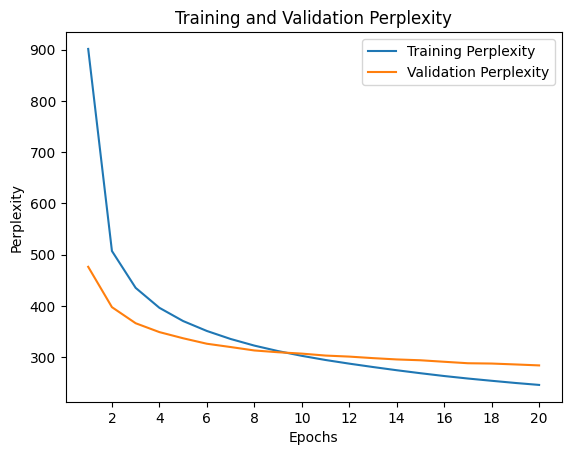

Perplexity on wiki2.test.txt: 

Loss: 5.5666 - test Perplexity: 261.5414

 Per-sentence Perplexity for examples.txt: 

origianl: The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers .
encoded:  The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . 
Loss: 5.4456 - example_sentence Perplexity: 231.7401
 
origianl: Its story was darker and more somber than that of its predecessor . The majority of material created for previous games , such as the <unk> system and the design of maps , was carried over .
encoded:  Its story was darker and more somber than that of its predec

In [ ]:
model = bengio(dim = opt["d_model"],
               num_hidden = opt["num_hidden"],
               window = opt["window"],
               vocab_size = len(opt["vocab"]),
               activation = torch.tanh)

model_retrieved = bengio(dim = opt["d_model"],
                         num_hidden = opt["num_hidden"],
                         window = opt["window"],
                         vocab_size = len(opt["vocab"]),
                         activation = torch.tanh)

if opt["no_cuda"] == False:
  model = model.cuda()
  model_retrieved = model_retrieved.cuda()

opt["optimizer"] = torch.optim.Adam(model.parameters(), lr = opt["lr"], betas = (0.9, 0.98), eps = 1e-9)

# To answer "What is the perplexity of your randomly initialized model before training?"
print("Perplexity before training: \n")

test_model(model, opt, test_dataset = "train")

test_model(model, opt, test_dataset = "test")


train(model, opt)

# save a copy to drive
shutil.copy(os.path.join("./model_weights", opt["savename"]), cs461dir)

# load the saved model and test
model_retrieved.load_state_dict(torch.load(os.path.join("./model_weights", opt["savename"]), weights_only = True))

print("Perplexity on wiki2.test.txt: \n")
test_model(model_retrieved, opt, test_dataset = "test")

# per-sentence Perplexity for example.txt
print("\n Per-sentence Perplexity for examples.txt: \n")
opt["examples"] = []
with open('examples.txt','rt') as f:
    for line in f:
        line = line.replace('\n','')
        encoded = encode(line,opt["words"])
        text = ''
        for i in range(len(encoded)):
            text = text + opt["vocab"][encoded[i]] + ' '
        opt["examples"].append(encoded)
        opt["example_sentence"] = encoded
        print('origianl: %s' % line)
        print('encoded:  %s' % text)
        test_model(model_retrieved, opt, test_dataset = "example_sentence")
        print(' ')